In [1]:

from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [2]:
times = ['time%s' % i for i in range(1, 11)]

train_df = pd.read_csv('train_sessions.csv',
                       index_col='session_id', parse_dates=times)

In [3]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [4]:
train_df['year'] = train_df['time1'].apply(lambda ts : ts.year)

In [5]:
train_df['month'] = train_df['time1'].apply(lambda ts : ts.month)

In [6]:
train_df['week'] = train_df['time1'].apply(lambda ts : ts.week)

In [7]:
train_df['day'] = train_df['time1'].apply(lambda ts : ts.day)

In [8]:
train_df['dow'] = train_df['time1'].apply(lambda ts : ts.date().weekday())

In [9]:
train_df['hour'] = train_df['time1'].apply(lambda ts : ts.hour)
train_df['sesslen'] = (train_df[times].max(axis = 1) - train_df[times].min(axis = 1)).apply(lambda ts: round(ts.seconds / 60))

In [10]:
train_df['num_urls'] = train_df[times].count(axis = 1)

In [11]:
train_df['active_days'] = (train_df['dow'].apply(lambda x : x in [0, 1, 3, 4]) ) * 1

In [12]:
train_df['session_lenght'] = round((train_df[times].max(axis = 1) - train_df[times].min(axis = 1)).apply(lambda ts: ts.seconds)/60)

In [13]:
train_df['active_hours'] = (train_df['hour'].apply(lambda x : x in [12, 13, 16, 17, 18]) ) * 1

In [14]:
train_df['sub10'] = (train_df['num_urls'] < 10) * 1

In [15]:
df = train_df

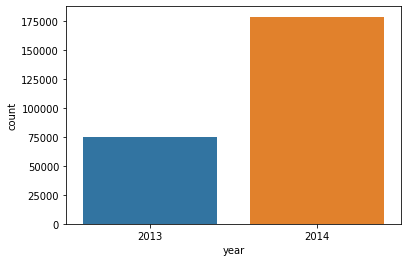

In [16]:
sns.countplot(data = df, x = 'year')

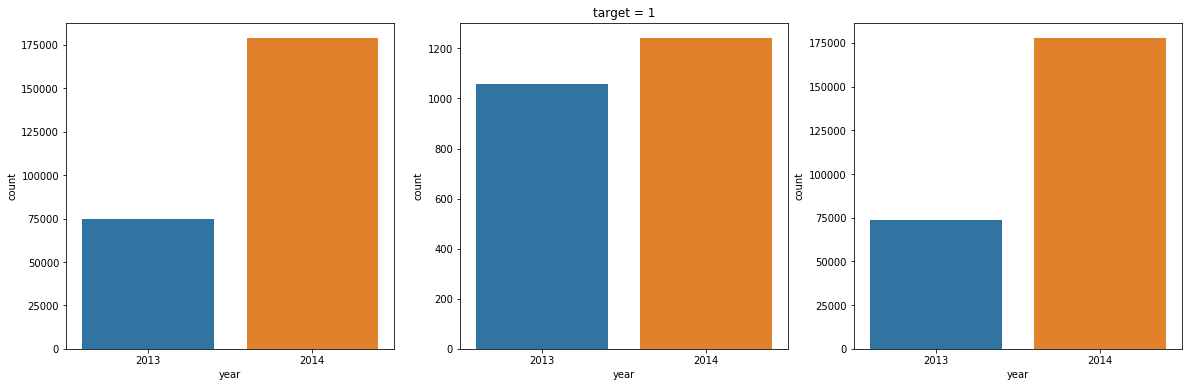

In [17]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.countplot(data = df, x = 'year')
plt.subplot(1, 3, 2)
plt.title('target = 1')
sns.countplot(data = df[df['target'] == 1], x = 'year')
plt.subplot(1, 3, 3)
sns.countplot(data = df[df['target'] == 0], x = 'year')

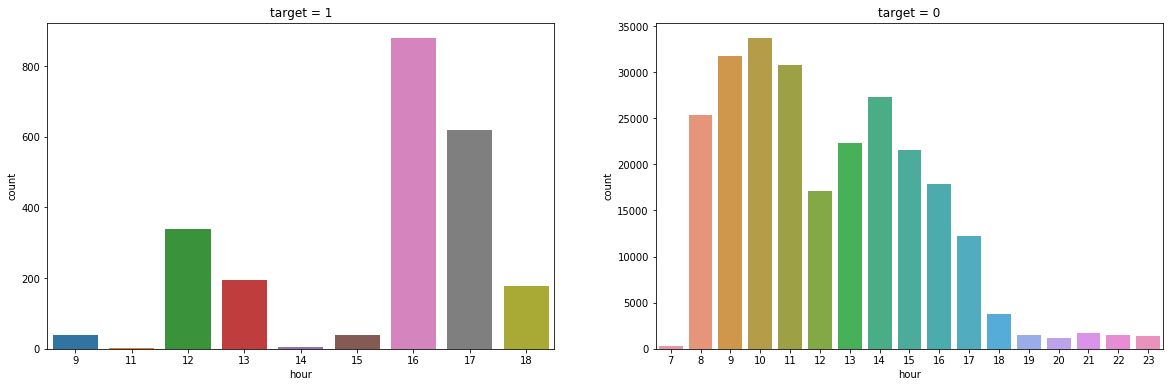

In [18]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title('target = 1')
sns.countplot(data = df[df['target'] == 1], x = 'hour')
plt.subplot(1, 2, 2)
plt.title('target = 0')
sns.countplot(data = df[df['target'] == 0], x = 'hour')


In [19]:
df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,week,day,dow,hour,sesslen,num_urls,active_days,session_lenght,active_hours,sub10
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,8,20,3,10,0,1,1,0.0,0,1
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,8,22,5,11,0,10,0,0.0,0,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,51,16,0,16,0,10,1,0.0,1,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,13,28,4,10,4,10,1,4.0,0,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,9,28,4,10,4,10,1,4.0,0,0


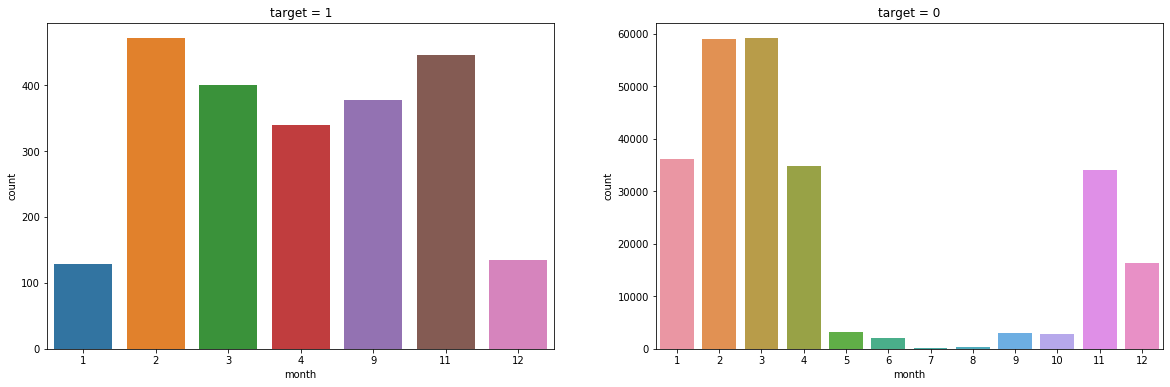

In [20]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title('target = 1')
sns.countplot(data = df[df['target'] == 1], x = 'month')
plt.subplot(1, 2, 2)
plt.title('target = 0')
sns.countplot(data = df[df['target'] == 0], x = 'month')

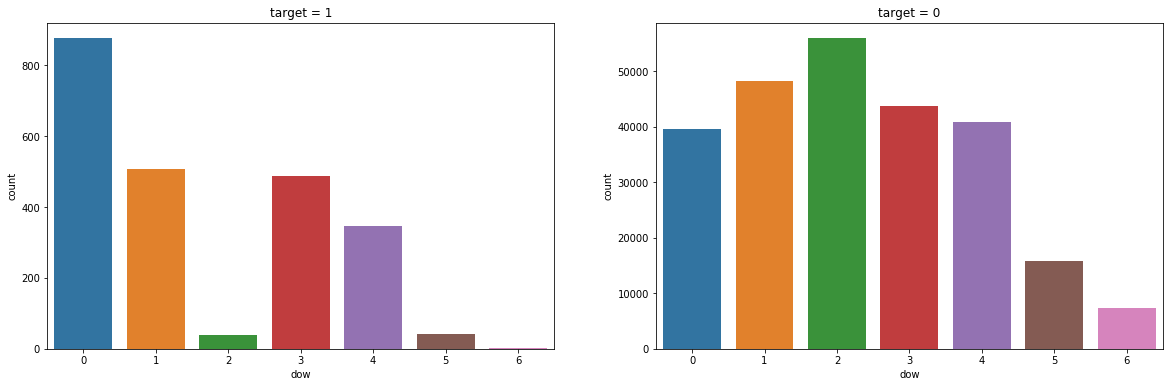

In [21]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title('target = 1')
sns.countplot(data = df[df['target'] == 1], x = 'dow')
plt.subplot(1, 2, 2)
plt.title('target = 0')
sns.countplot(data = df[df['target'] == 0], x = 'dow')

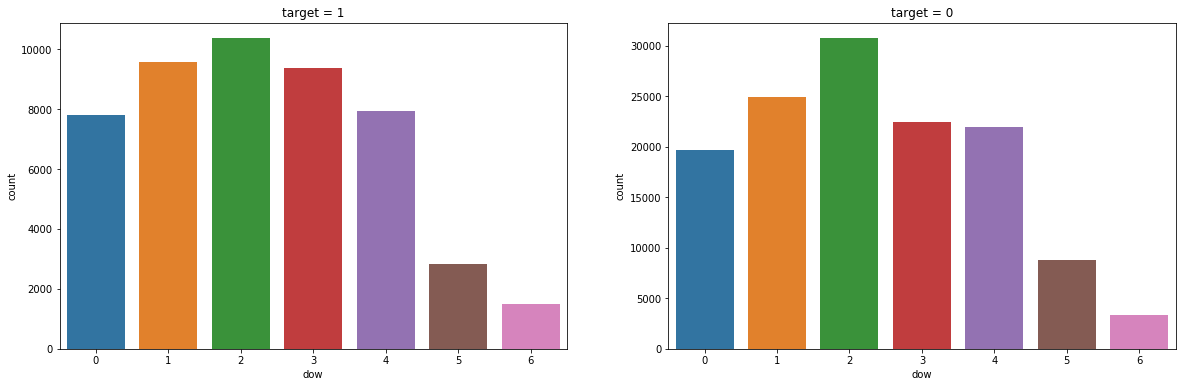

In [22]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title('target = 1')
sns.countplot(data = df[df['sesslen'] == 1], x = 'dow')
plt.subplot(1, 2, 2)
plt.title('target = 0')
sns.countplot(data = df[df['sesslen'] == 0], x = 'dow')

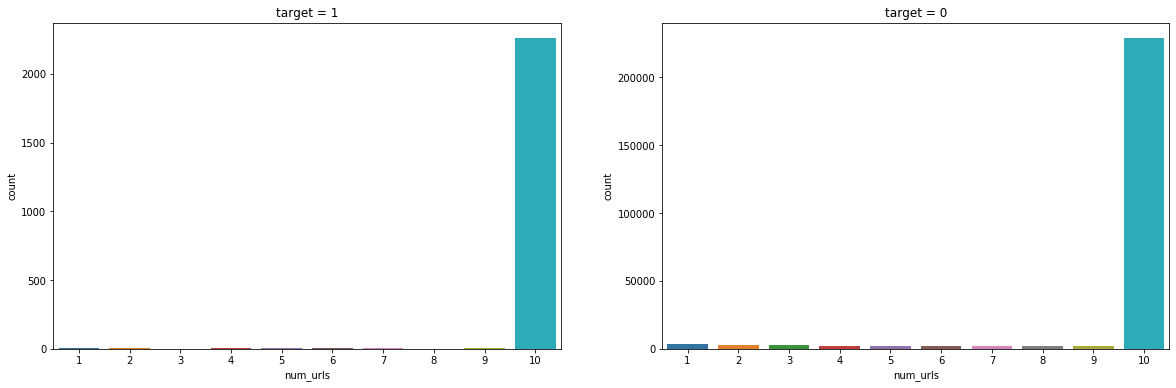

In [23]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title('target = 1')
sns.countplot(data = df[df['target'] == 1], x = 'num_urls')
plt.subplot(1, 2, 2)
plt.title('target = 0')
sns.countplot(data = df[df['target'] == 0], x = 'num_urls')

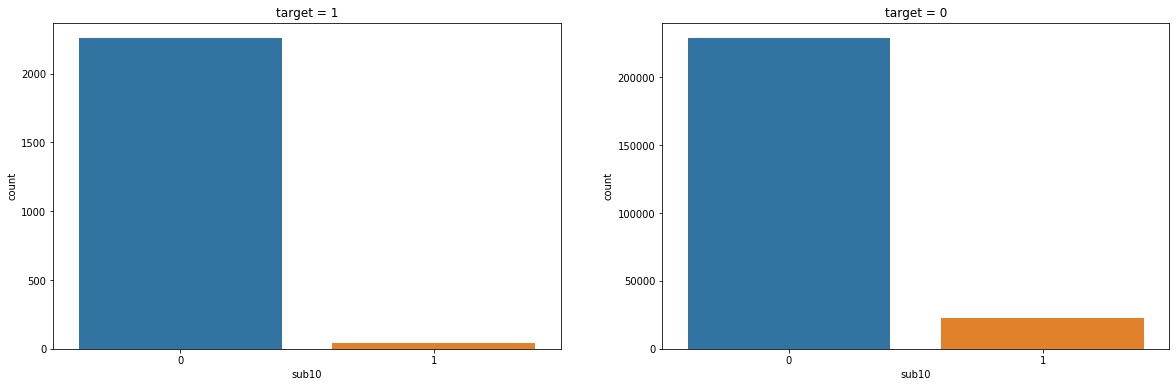

In [24]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title('target = 1')
sns.countplot(data = df[df['target'] == 1], x = 'sub10')
plt.subplot(1, 2, 2)
plt.title('target = 0')
sns.countplot(data = df[df['target'] == 0], x = 'sub10')

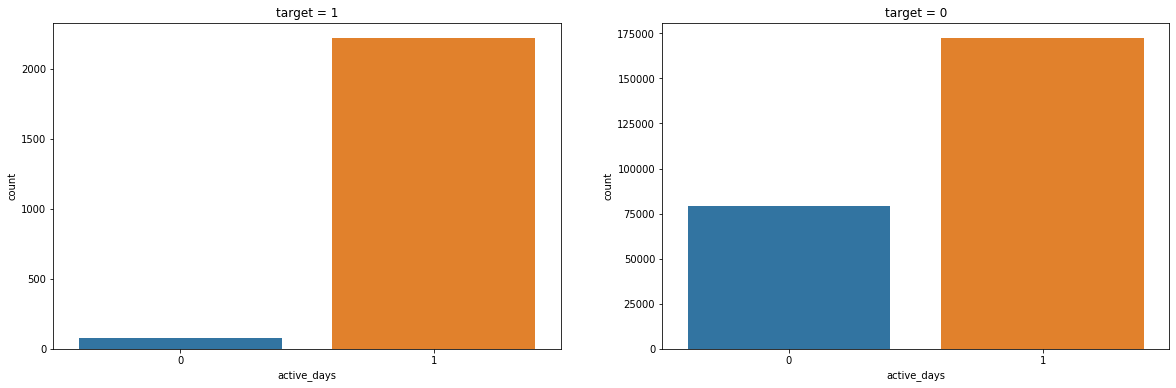

In [25]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title('target = 1')
sns.countplot(data = df[df['target'] == 1], x = 'active_days')
plt.subplot(1, 2, 2)
plt.title('target = 0')
sns.countplot(data = df[df['target'] == 0], x = 'active_days')

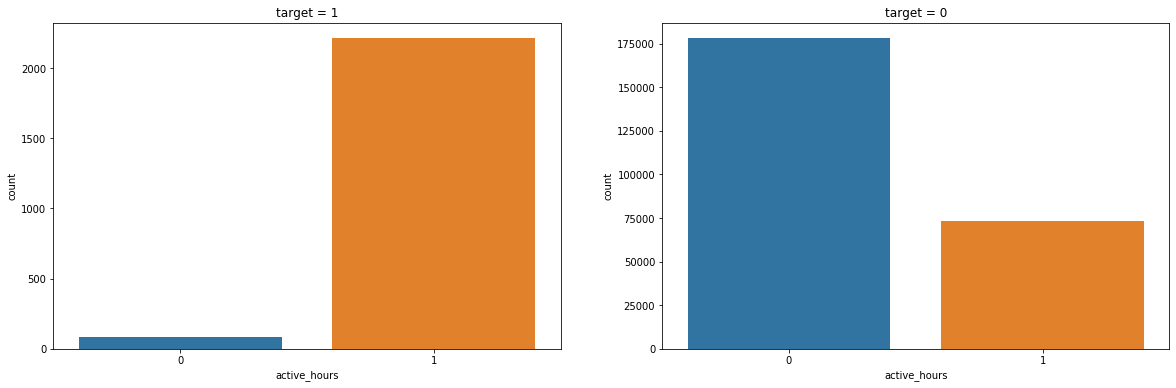

In [26]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title('target = 1')
sns.countplot(data = df[df['target'] == 1], x = 'active_hours')
plt.subplot(1, 2, 2)
plt.title('target = 0')
sns.countplot(data = df[df['target'] == 0], x = 'active_hours')

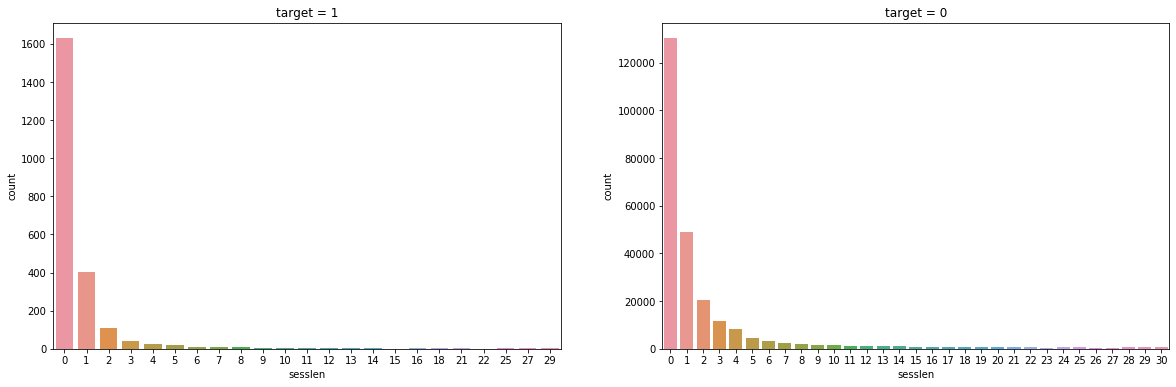

In [28]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.title('target = 1')
sns.countplot(data = df[df['target'] == 1], x = 'sesslen')
plt.subplot(1, 2, 2)
plt.title('target = 0')
sns.countplot(data = df[df['target'] == 0], x = 'sesslen')

In [ ]:
df.head()